# Control Engineering with gwexpy - Part 1: Data & Spectral Analysis

**Goal**: Master the basics of handling experimental data, estimating spectra (ASD/PSD), and calculating Transfer Functions using `gwexpy`.

This notebook focuses on the **"Measurement"** phase of control engineering: getting reliable frequency-domain data from time-domain signals.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal

import gwexpy
from gwexpy import TimeSeries

print(f"gwexpy version: {gwexpy.__version__}")

gwexpy version: 0.1.0b1


## 1. Data Generation (Simulating an Experiment)

In a real experiment, you would load data from files (NDS, HDF5, etc.).
Here, we simulate a **System Identification** experiment:
1.  **Input ($u$)**: White Gaussian Noise (Excitation signal).
2.  **Plant ($P$)**: A simple resonance system.
3.  **Output ($y$)**: The system's response ($y = P u$).

In [3]:
# Configuration
fs = 1024  # Sampling rate (Hz)
duration = 60  # Duration (seconds)
t = np.arange(0, duration, 1 / fs)

# 1. Generate Input Noise (u)
np.random.seed(42)
u_data = np.random.randn(len(t))
u = TimeSeries(u_data, times=t, unit="V", name="Input (Drive)")

# 2. Define Plant Process (2nd order resonance)
# f0 = 10 Hz, Q = 10
f0 = 10
Q = 10
w0 = 2 * np.pi * f0
num = [w0**2]
den = [1, w0 / Q, w0**2]

# 3. Simulate Output (y) using scipy
sys_dt = signal.cont2discrete((num, den), 1 / fs)
y_data = signal.dlti(sys_dt[0], sys_dt[1], dt=1 / fs).output(u.value, t=t)[1]
# y_data comes out as (N, 1), flatten it
y_data = y_data.flatten()

y = TimeSeries(y_data, times=t, unit="m", name="Output (Displacement)")

print("Data generated successfully.")

Data generated successfully.


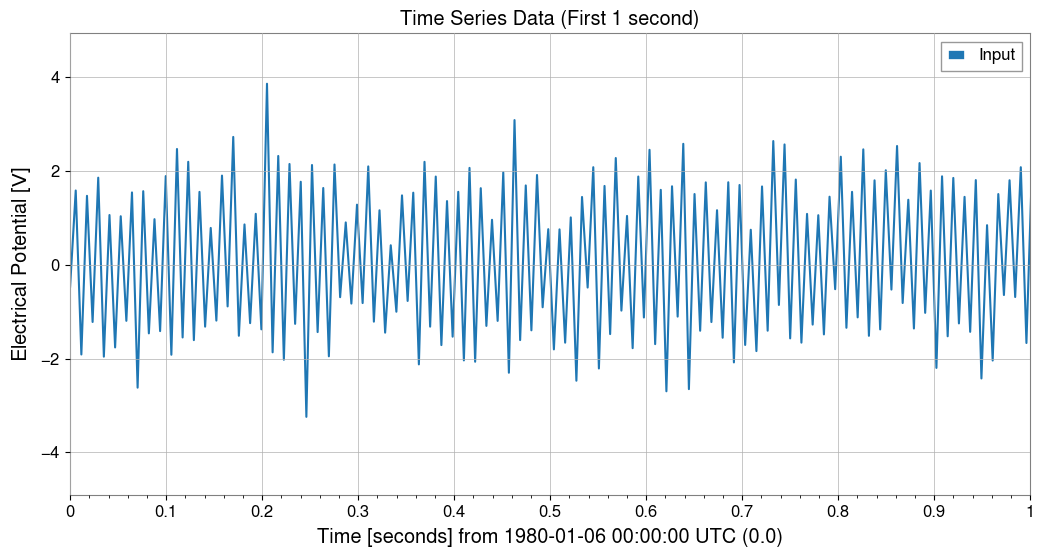

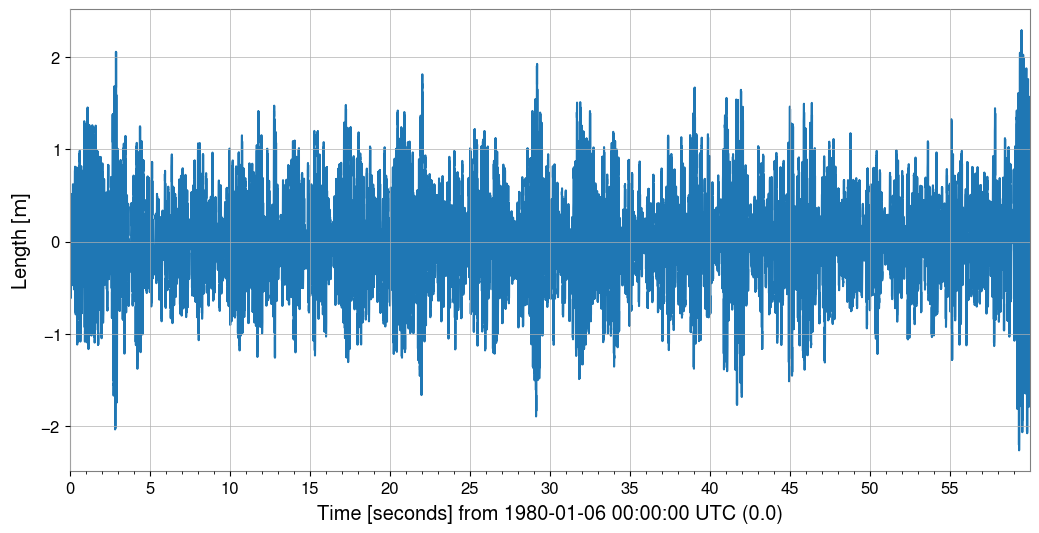

In [4]:
# Plot a short segment to visualize
plot = u.plot(label="Input")
ax = plot.gca()
y.plot(ax=ax, label="Output")
ax.set_xlim(0, 1)
ax.legend()
ax.set_title("Time Series Data (First 1 second)")
plt.show()

## 2. Spectral Density Estimation (ASD/PSD)

We characterize the signals in the frequency domain using **Amplitude Spectral Density (ASD)**.
`gwexpy.TimeSeries` provides `.asd()` method (wrapper around Welch's method).

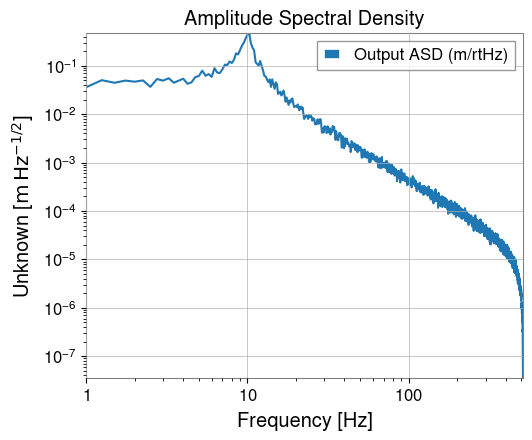

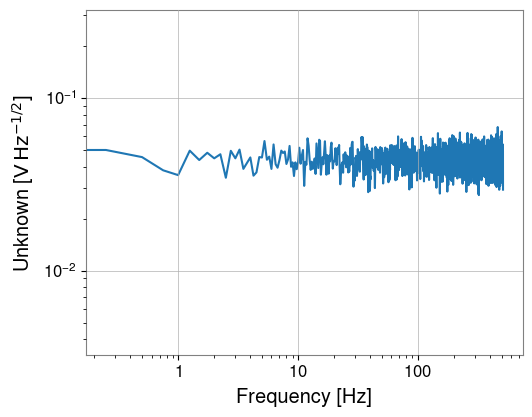

In [5]:
# Calculate ASDs
# fftlength: Length of each segment in seconds (inverse of freq resolution)
fftlength = 4  # 0.25 Hz resolution

asd_u = u.asd(fftlength=fftlength)
asd_y = y.asd(fftlength=fftlength)

# Plot
plot = asd_y.plot(label="Output ASD (m/rtHz)")
ax = plot.gca()
asd_u.plot(ax=ax, label="Input ASD (V/rtHz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1, fs / 2)
ax.legend()
ax.set_title("Amplitude Spectral Density")
plt.show()

## 3. Coherence

**Coherence** measures the linearity and correlation between input and output.
- Value near 1: Good linear relationship (high SNR).
- Value near 0: Noise dominated or non-linear.

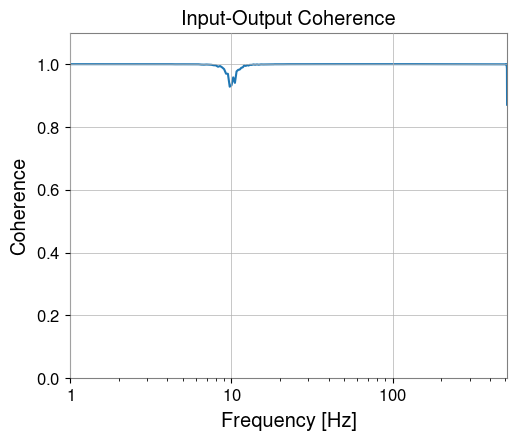

In [6]:
coh = u.coherence(y, fftlength=fftlength)

plot = coh.plot()
ax = plot.gca()
ax.set_xscale("log")
ax.set_yscale("linear")
ax.set_xlim(1, fs / 2)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Coherence")
ax.set_title("Input-Output Coherence")
plt.show()

## 4. Transfer Function Estimate

The **Transfer Function (TF)** is the frequency response of the system: $H(f) = Y(f) / U(f)$.
We obtain it using `transfer_function` method.

**Note**: In experimental data, TF is usually estimated as $P_{xy} / P_{xx}$ (H1 estimate) or $P_{yy} / P_{yx}$ (H2 estimate).

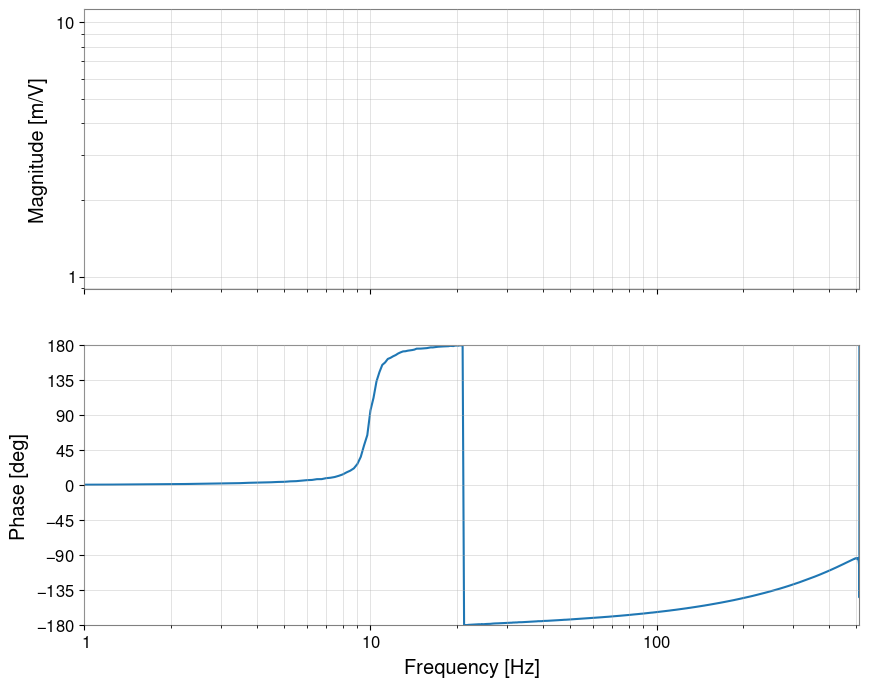

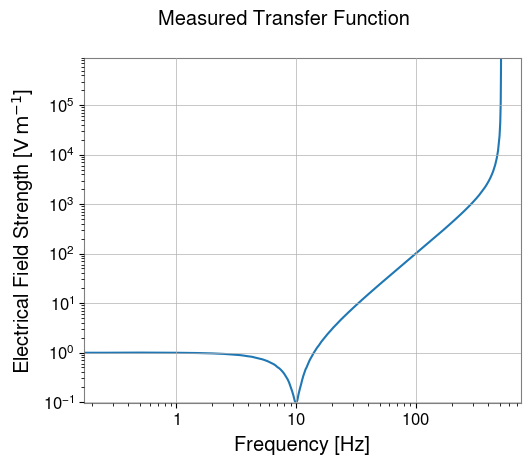

In [7]:
tf_meas = y.transfer_function(u, fftlength=fftlength)
# tf_meas is a FrequencySeries with complex values

# Create Bode Plot
fig, (ax_mag, ax_phase) = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Magnitude
tf_meas.abs().plot(ax=ax_mag)
ax_mag.set_yscale("log")
ax_mag.set_ylabel("Magnitude [m/V]")
ax_mag.grid(True, which="both", linestyle="-", alpha=0.5)

# Phase
# We use angle() method if available, or numpy
freqs = tf_meas.frequencies.value
phase_deg = np.rad2deg(np.angle(tf_meas.value))

ax_phase.semilogx(freqs, phase_deg)
ax_phase.set_ylabel("Phase [deg]")
ax_phase.set_xlabel("Frequency [Hz]")
ax_phase.set_ylim(-180, 180)
ax_phase.set_yticks(np.arange(-180, 181, 45))
ax_phase.grid(True, which="both", linestyle="-", alpha=0.5)
ax_phase.set_xlim(1, fs / 2)

plt.suptitle("Measured Transfer Function")
plt.show()

In [8]:
print(
    "Tutorial 01 Complete. In the next tutorial, we will fit a model to this measured Transfer Function."
)

Tutorial 01 Complete. In the next tutorial, we will fit a model to this measured Transfer Function.
